In [1]:
import pandas as pd
import pickle
import gcsfs

import seaborn as sns

from count_modeling.utils import get_model_data
from count_modeling.constants import CURRENT_MODEL_DATA_VERSION, MODEL_PATH

In [2]:
#read in models
MODEL_VERSION = '2023-05-24T08:35:37.020376-07:00'

fs = gcsfs.GCSFileSystem()
with fs.open(MODEL_PATH.format(version=MODEL_VERSION), 'rb') as fi:
    models = pickle.load(fi)

In [3]:
display(pd.DataFrame(models).T)

,in_sample_rmse,out_sample_rmse,model
dummy,287.41111,172.047387,DummyRegressor()
vanilla_poisson,172.42426,147.118381,(ColumnTransformer(transformers=[('categorical...
rfr,144.519906,131.831806,(ColumnTransformer(transformers=[('categorical...
gbr,305325.418199,215748.782432,(ColumnTransformer(transformers=[('categorical...


In [4]:
best_model = models['rfr']['model']

<AxesSubplot:>

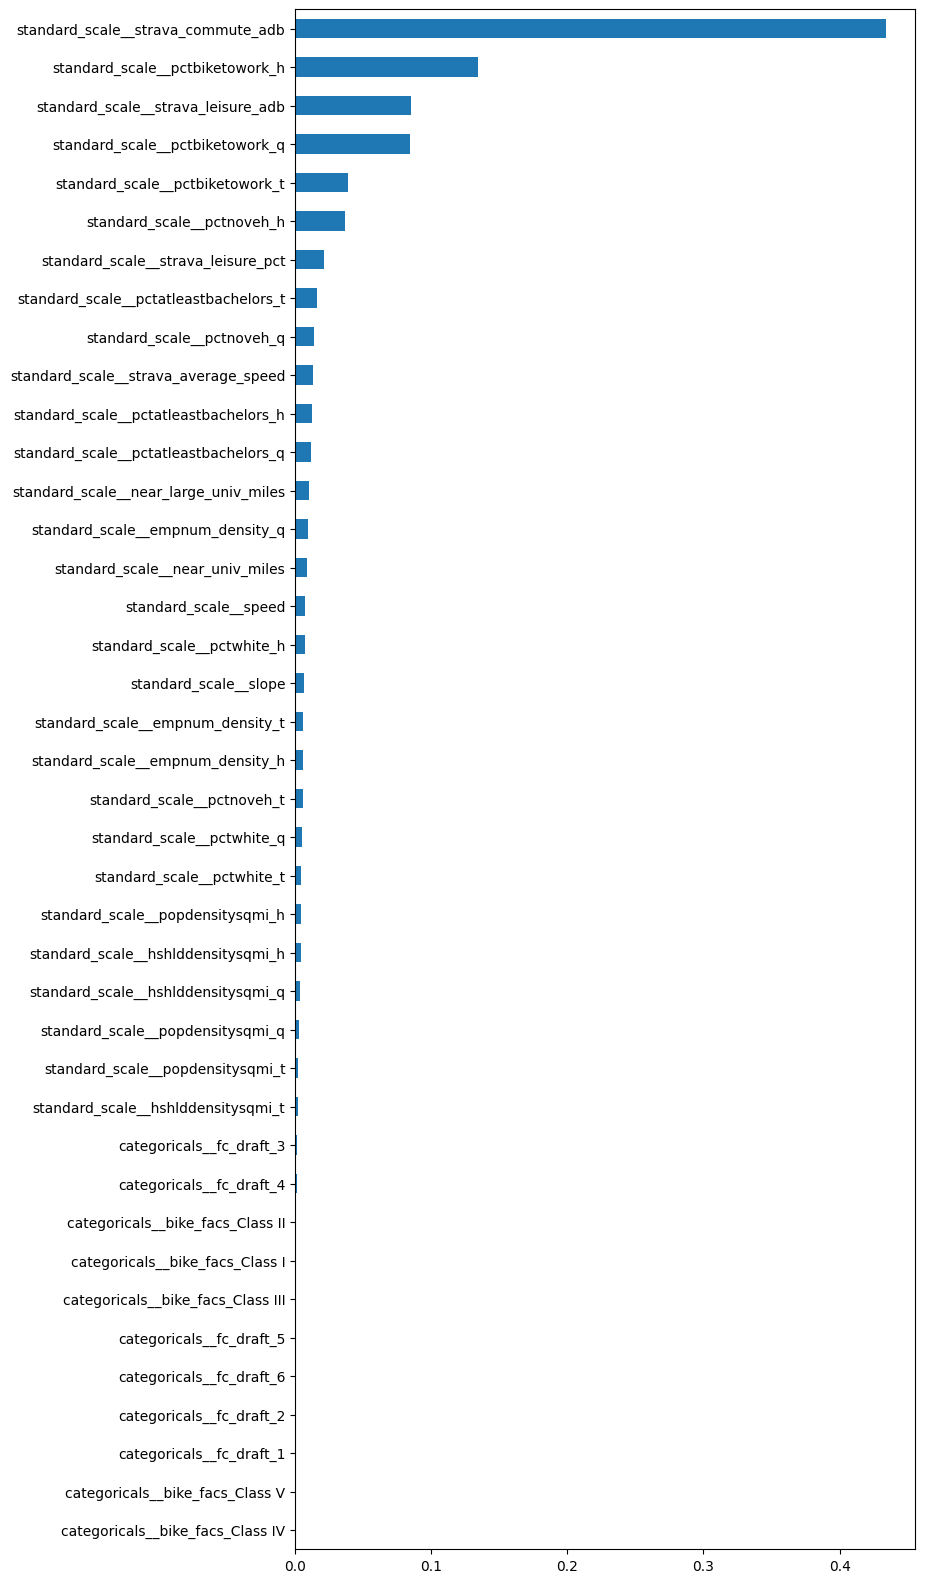

In [5]:
pd.Series(
    best_model['rfr'].feature_importances_,
    index=best_model[:-1].get_feature_names_out()).sort_values().plot(kind='barh', figsize=(8, 20))

In [6]:
important_model_cols = ['strava_commute_adb', 'strava_leisure_adb', 'pctbiketowork_h',
                        'pctbiketowork_q', 'pctbiketowork_t', 'pctnoveh_h']

In [7]:
X_train, X_test, y_train, y_test, context_train, context_test = get_model_data(CURRENT_MODEL_DATA_VERSION)

In [8]:
residual_df = context_train.join(X_train).join(y_train)

In [9]:
residual_df['y_pred'] = best_model.predict(X_train)
residual_df['y_resid'] = residual_df['AADB'] - residual_df['y_pred']
residual_df['y_resid_pct'] = residual_df['y_resid'] / residual_df['y_pred']
residual_df['abs_y_resid'] = residual_df['y_resid'].abs()

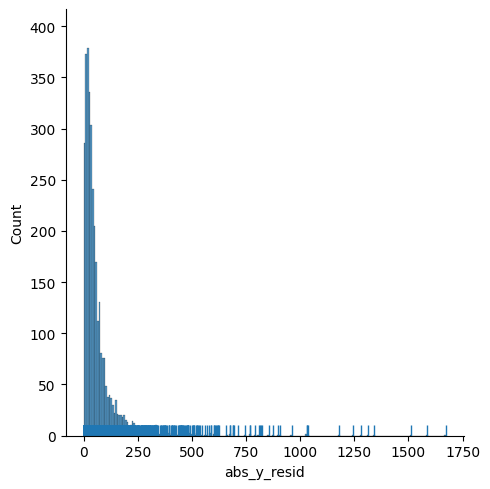

In [10]:
sns.displot(residual_df.abs_y_resid, rug=True)

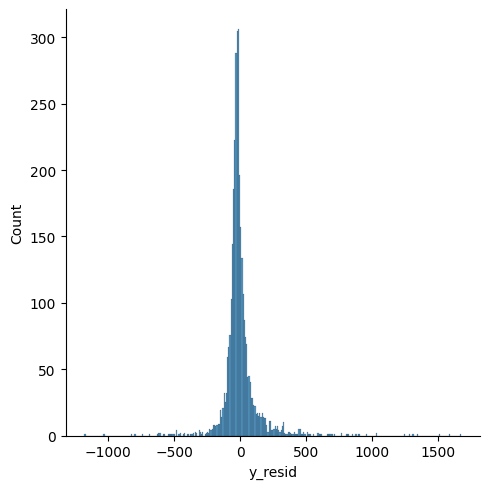

In [11]:
sns.displot(residual_df.y_resid)

So it looks like our RMSD is being driven by some egregious outliers. Positive values mean we're underpredicting, negative values mean we're overpredicting.

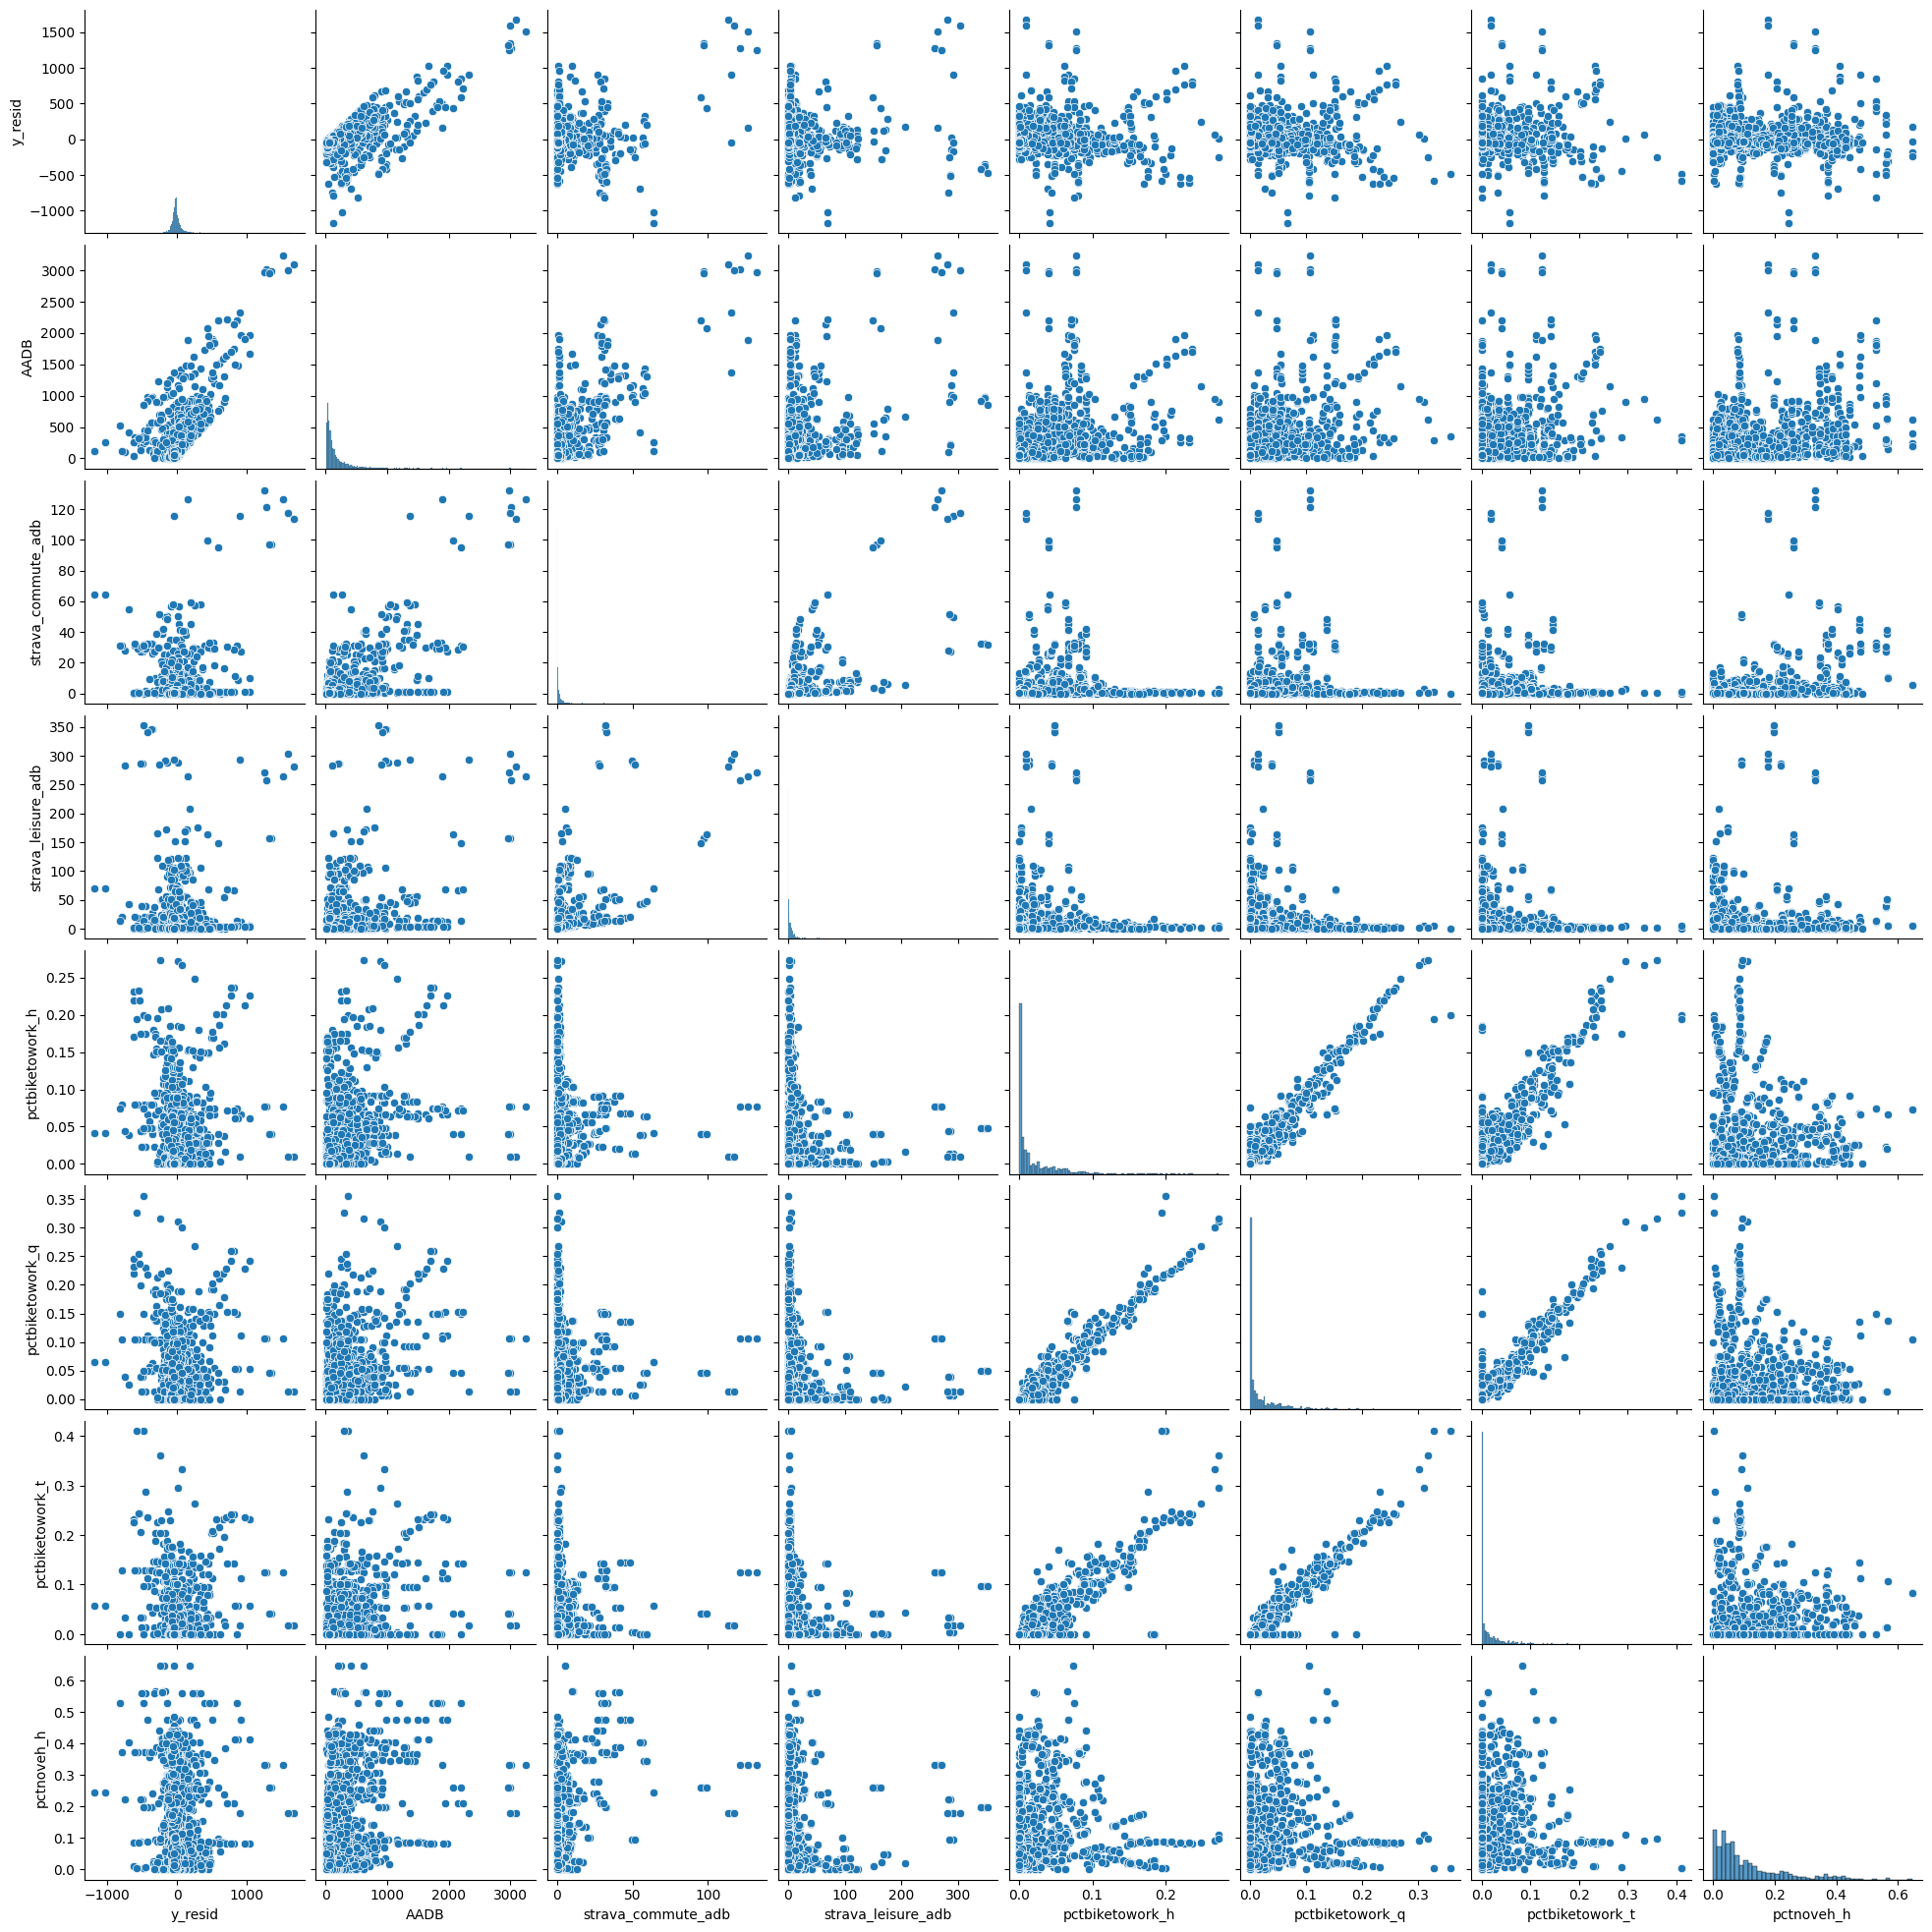

In [12]:
sns.pairplot(residual_df[['y_resid', 'AADB'] + important_model_cols])

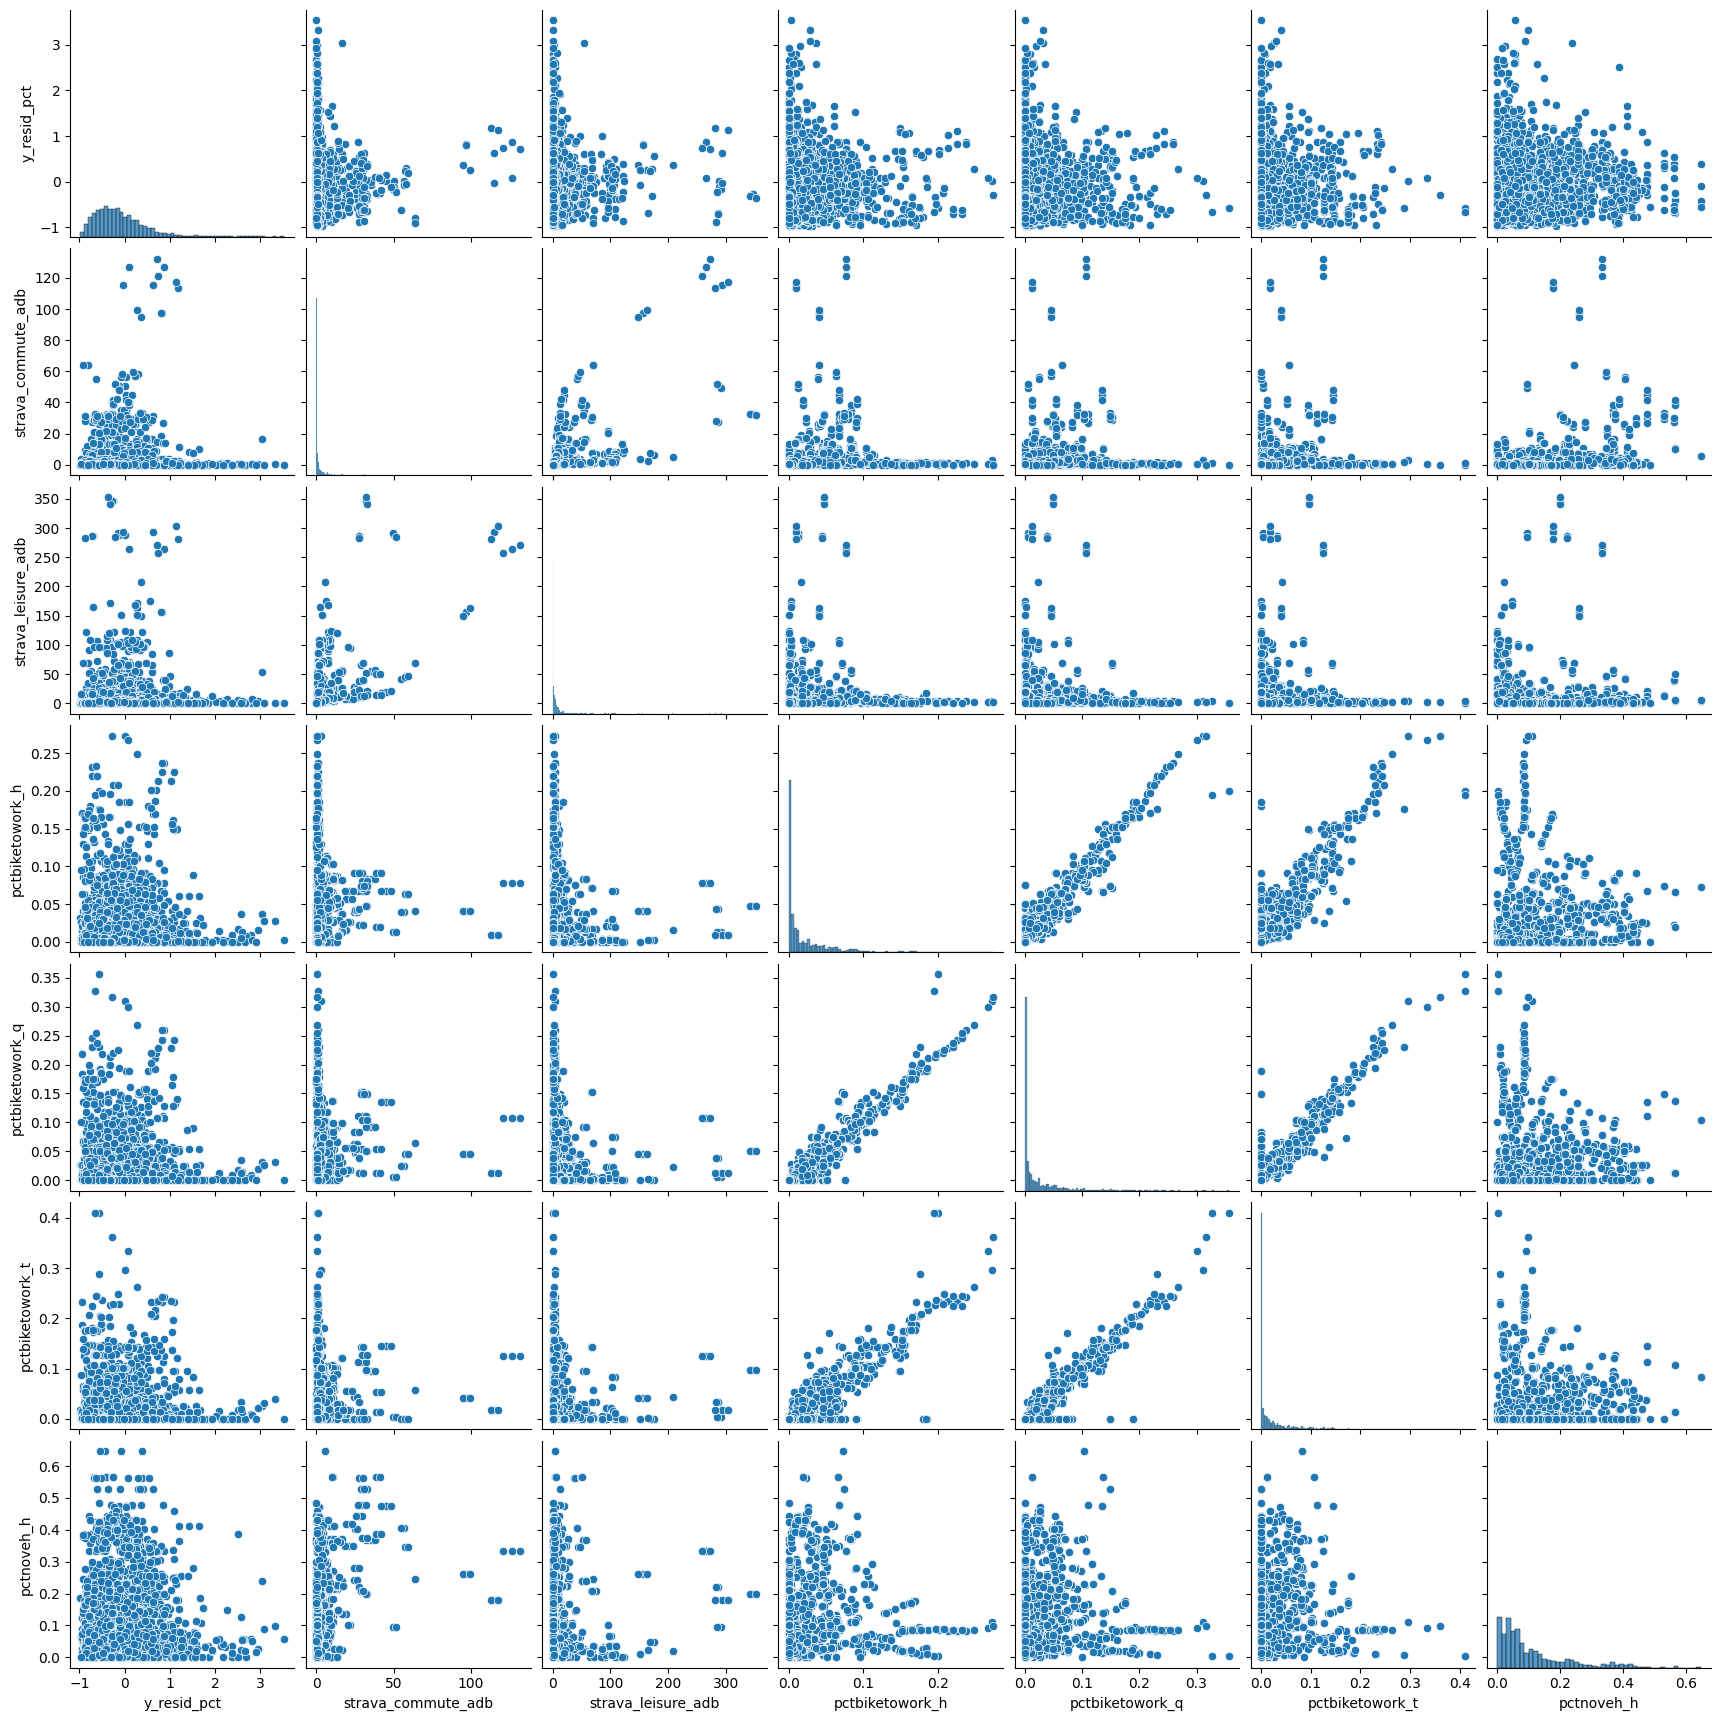

In [13]:
sns.pairplot(residual_df[['y_resid_pct'] + important_model_cols])

In [14]:
cols_for_map = ['AADB', 'y_pred', 'y_resid', 'centroid', 'year', 'no_of_months_data_collected', 'type'] + important_model_cols

Recall these are underpredictions:

In [53]:
residual_df[cols_for_map].query('y_resid > 250').explore('y_resid', cmap='hot_r', marker_kwds={'radius': 10})

And these are overpredictions

In [50]:
residual_df[cols_for_map].query('y_resid < -250').explore('y_resid', cmap='hot', marker_kwds={'radius': 10})